# Facebook Prophet

In [47]:
 
import plotly.io as pio
pio.renderers.default = "colab+notebook_connected+vscode"

import pandas as pd
import numpy as np
import duckdb as db
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import optuna
import warnings

import seaborn as sns
sns.set_style("whitegrid")

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

# mape
from sklearn.metrics import mean_absolute_percentage_error

optuna.logging.set_verbosity(optuna.logging.ERROR)

# facebook prophet
from prophet import Prophet
from IPython.display import clear_output

In [48]:
orig = pd.read_parquet("../../data/processed/train_enhanced.parquet")
train_agg = pd.read_parquet("../../data/processed/train_agg.parquet")
train_region_code_agg = pd.read_parquet("../../data/processed/train_region_code_agg.parquet")
holiday_df= pd.read_csv("../../data/processed/holidays.csv")

# Individual Region Forecasting

In [14]:
train_region_code_agg

,Date,Region_Code,Total_Sales,Avg_Sales,Total_Orders,Avg_Orders,Num_Stores,Holiday,Total_Discounts
0,2018-01-01,R4,2286812,45736,2914,58,50,1,50
1,2018-01-01,R2,4436859,42256,5644,54,105,1,105
2,2018-01-01,R3,3527439,41017,4599,53,86,1,86
3,2018-01-01,R1,5094374,41084,6509,52,124,1,124
4,2018-01-02,R4,2545119,50902,3057,61,50,0,50
...,...,...,...,...,...,...,...,...,...
2059,2019-05-30,R4,1966320,39326,2829,57,50,0,4
2060,2019-05-31,R2,4351299,41441,6411,61,105,1,11
2061,2019-05-31,R4,1909319,38186,2746,55,50,1,1
2062,2019-05-31,R1,5900798,47587,9433,76,124,1,18


In [49]:
holiday_df = holiday_df[holiday_df["Holiday"]==1]
holiday_df = holiday_df.rename(columns={"Date": "ds", "Holiday": "holiday"})
holiday_df["holiday"] = "Holiday"
holiday_df

,ds,holiday
2,2019-01-13,Holiday
10,2019-03-21,Holiday
14,2019-04-14,Holiday
15,2019-04-17,Holiday
16,2019-04-19,Holiday
...,...,...
483,2018-03-02,Holiday
505,2018-10-02,Holiday
506,2018-10-18,Holiday
508,2018-11-13,Holiday


In [21]:
df = train_region_code_agg[["Date", "Region_Code", "Total_Sales","Total_Discounts"  ]].rename(columns={"Date": "ds", "Total_Sales": "y"})
df.head(10)

,ds,Region_Code,y,Total_Discounts
0,2018-01-01,R4,2286812,50
1,2018-01-01,R2,4436859,105
2,2018-01-01,R3,3527439,86
3,2018-01-01,R1,5094374,124
4,2018-01-02,R4,2545119,50
5,2018-01-02,R2,5373945,105
6,2018-01-02,R1,7050675,124
7,2018-01-02,R3,4622676,86
8,2018-01-03,R3,4306149,86
9,2018-01-03,R1,6851526,124


In [50]:
print("Min date:", df["ds"].min(), ", Max ds:", df["ds"].max())

total_days = (df["ds"].max() - df["ds"].min()).days
train_max = df["ds"].min() + pd.DateOffset(days=total_days * 0.8)
print("Total days:", total_days, ", Training days: ",total_days * 0.8 )
print("Train max date:", train_max)

Min date: 2018-01-01 00:00:00 , Max ds: 2019-05-31 00:00:00
Total days: 515 , Training days:  412.0
Train max date: 2019-02-17 00:00:00


In [18]:
train = df[df["ds"] <= train_max]
test = df[df["ds"] > train_max]

In [19]:
region_1_train = train[train["Region_Code"]=="R1"].drop(columns=["Region_Code"], axis=1)
region_1_test = test[test["Region_Code"]=="R1"].drop(columns=["Region_Code"], axis=1)

region_2_train = train[train["Region_Code"]=="R2"].drop(columns=["Region_Code"], axis=1)
region_2_test = test[test["Region_Code"]=="R2"].drop(columns=["Region_Code"], axis=1)

region_3_train = train[train["Region_Code"]=="R3"].drop(columns=["Region_Code"], axis=1)
region_3_test = test[test["Region_Code"]=="R3"].drop(columns=["Region_Code"], axis=1)

region_4_train = train[train["Region_Code"]=="R4"].drop(columns=["Region_Code"], axis=1)
region_4_test = test[test["Region_Code"]=="R4"].drop(columns=["Region_Code"], axis=1)

In [20]:
region_1_train

,ds,y,Total_Discounts
3,2018-01-01,5094374,124
6,2018-01-02,7050675,124
9,2018-01-03,6851526,124
12,2018-01-04,7362648,124
19,2018-01-05,8153604,124
...,...,...,...
1635,2019-02-13,4751202,20
1636,2019-02-14,4994766,58
1641,2019-02-15,5260713,99
1646,2019-02-16,6426930,108


In [22]:
m = Prophet(holidays=holiday_df, yearly_seasonality=True, weekly_seasonality=True, seasonality_mode="multiplicative", holidays_prior_scale=0.01, seasonality_prior_scale=0.01, changepoint_prior_scale=0.01)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
# m.add_seasonality(name='fortnightly', period=12, fourier_order=5)
# m.add_regressor("Num_Stores")
m.add_regressor("Total_Discounts")

In [23]:
m.fit(region_1_train)
forecast = m.predict(region_1_test.drop(columns=["y"], axis=1));

23:20:11 - cmdstanpy - INFO - Chain [1] start processing
23:20:11 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
fig = px.line(forecast, x='ds', y='yhat', title='Sales Forecast')
fig.add_scatter(x=region_1_test["ds"], y=region_1_test["y"], mode='lines', name='Actual Sales')
# plot confidence intervals
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill=None, mode='lines', line_color='lightblue', name='Upper Bound'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='lines', line_color='lightblue', name='Lower Bound'))
fig.show()

In [25]:
mean_absolute_percentage_error(region_1_test["y"], forecast["yhat"])

0.17934474374706313

# Hyperparameter tuning 

In [ ]:
for region in [1,2,3,4]:
    data_train = eval(f"region_{region}_train")
    data_test = eval(f"region_{region}_test")
    def objective(trial):
        changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5)
        seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10)
        holidays_prior_scale = trial.suggest_loguniform('holidays_prior_scale', 0.01, 10)
        seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
        m = Prophet(holidays=holiday_df, yearly_seasonality=True, weekly_seasonality=True, seasonality_mode=seasonality_mode, holidays_prior_scale=holidays_prior_scale, seasonality_prior_scale=seasonality_prior_scale, changepoint_prior_scale=changepoint_prior_scale)
        m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        # m.add_regressor("Num_Stores")
        m.add_regressor("Total_Discounts")
        m.fit(data_train)
        forecast = m.predict(data_test.drop(columns=["y"], axis=1))
        mape = mean_absolute_percentage_error(data_test["y"], forecast["yhat"])
        return mape

    study = optuna.create_study(direction='minimize', study_name=f'prophet_region_{region}', storage='sqlite:///optuna.db', load_if_exists=True)
    study.optimize(objective, n_trials=500);

    clear_output()
    print(f"Region {region} done")

In [34]:
study.best_value

0.16044228296575438

In [36]:
for region in [1,2,3,4]:
    study = optuna.load_study(study_name=f"prophet_region_{region}", storage='sqlite:///optuna.db')
    print(f"Region {region} best MAPE value: {study.best_value}")

Region 1 best MAPE value: 0.15225036584129845
Region 2 best MAPE value: 0.13027288910762835
Region 3 best MAPE value: 0.15323658067181525
Region 4 best MAPE value: 0.16044228296575438


# Global Forecasting

In [51]:
train_agg

,Date,Total_Sales,Avg_Sales,Total_Orders,Avg_Orders,Holiday,Total_Discounts
0,2018-01-01,15345484,42042,19666,54,1,365
1,2018-01-02,19592415,53678,25326,69,0,365
2,2018-01-03,18652527,51103,24047,66,0,365
3,2018-01-04,19956267,54675,25584,70,0,364
4,2018-01-05,22902651,62747,28436,78,0,364
...,...,...,...,...,...,...,...
511,2019-05-27,17197023,47115,25447,70,0,321
512,2019-05-28,18652065,51102,27184,74,0,319
513,2019-05-29,16213497,44421,24047,66,0,193
514,2019-05-30,16082139,44061,24318,67,0,76


In [24]:
px.line(train_agg, x='Date', y='Total_Sales', title='Total Sales')

In [52]:
df = train_agg[["Date", "Total_Sales", "Total_Discounts"  ]].rename(columns={"Date": "ds", "Total_Sales": "y"})
df

,ds,y,Total_Discounts
0,2018-01-01,15345484,365
1,2018-01-02,19592415,365
2,2018-01-03,18652527,365
3,2018-01-04,19956267,364
4,2018-01-05,22902651,364
...,...,...,...
511,2019-05-27,17197023,321
512,2019-05-28,18652065,319
513,2019-05-29,16213497,193
514,2019-05-30,16082139,76


In [53]:
train = df[df["ds"] <= train_max]
test = df[df["ds"] > train_max]

In [54]:
test

,ds,y,Total_Discounts
413,2019-02-18,16319103,319
414,2019-02-19,15816166,222
415,2019-02-20,12800094,59
416,2019-02-21,12383694,37
417,2019-02-22,11743965,10
...,...,...,...
511,2019-05-27,17197023,321
512,2019-05-28,18652065,319
513,2019-05-29,16213497,193
514,2019-05-30,16082139,76


In [ ]:
def objective(trial):
    changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5)
    seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10)
    holidays_prior_scale = trial.suggest_loguniform('holidays_prior_scale', 0.01, 10)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
    m = Prophet(holidays=holiday_df, yearly_seasonality=True, weekly_seasonality=True, seasonality_mode=seasonality_mode, holidays_prior_scale=holidays_prior_scale, seasonality_prior_scale=seasonality_prior_scale, changepoint_prior_scale=changepoint_prior_scale)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.add_regressor("Total_Discounts")
    m.fit(train)
    forecast = m.predict(test.drop(columns=["y"], axis=1))
    mape = mean_absolute_percentage_error(test["y"], forecast["yhat"])
    return mape

study = optuna.create_study(direction='minimize', study_name='prophet_global', storage='sqlite:///optuna.db', load_if_exists=True)
study.optimize(objective, n_trials=500)

In [55]:
study = optuna.load_study(study_name='prophet_global', storage='sqlite:///optuna.db')

In [56]:
study.best_params

{'changepoint_prior_scale': 0.012362843872258014,
 'seasonality_prior_scale': 8.096622322215257,
 'holidays_prior_scale': 0.377892692067135,
 'seasonality_mode': 'additive'}

In [57]:
m = Prophet(holidays=holiday_df, yearly_seasonality=True, weekly_seasonality=True, **study.best_params)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_regressor("Total_Discounts")
m.fit(train)
forecast = m.predict(test.drop(columns=["y"], axis=1))


14:52:48 - cmdstanpy - INFO - Chain [1] start processing
14:52:48 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
fig = px.line(forecast, x='ds', y='yhat', title='Sales Forecast')
fig.add_scatter(x=test["ds"], y=test["y"], mode='lines', name='Actual Sales')
# plot confidence intervals
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill=None, mode='lines', line_color='lightblue', name='Upper Bound'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='lines', line_color='lightblue', name='Lower Bound'))
fig.show()

In [36]:
mean_absolute_percentage_error(test["y"], forecast["yhat"])

0.14755801506495533

In [58]:
resid_df=(test.reset_index()["y"] - forecast.reset_index()["yhat"]).to_frame().rename(columns={0: "Residuals"})

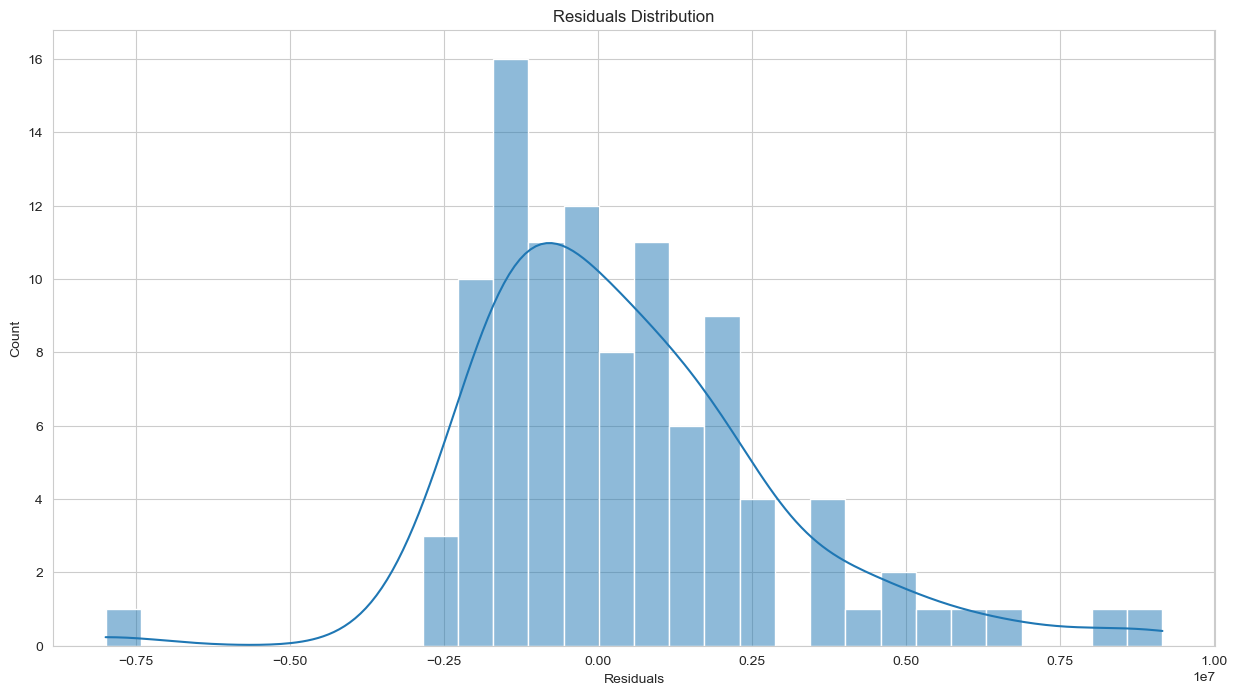

In [59]:
plt.figure(figsize=(15, 8))
sns.histplot(resid_df["Residuals"], kde=True, bins=30);
plt.title("Residuals Distribution");

In [60]:
test

,ds,y,Total_Discounts
413,2019-02-18,16319103,319
414,2019-02-19,15816166,222
415,2019-02-20,12800094,59
416,2019-02-21,12383694,37
417,2019-02-22,11743965,10
...,...,...,...
511,2019-05-27,17197023,321
512,2019-05-28,18652065,319
513,2019-05-29,16213497,193
514,2019-05-30,16082139,76


In [64]:
forecast["yhat"]

0      1.683457e+07
1      1.180086e+07
2      1.356270e+07
3      1.351707e+07
4      1.332159e+07
           ...     
98     1.720491e+07
99     1.624991e+07
100    1.522750e+07
101    1.418699e+07
102    1.072965e+07
Name: yhat, Length: 103, dtype: float64

In [70]:
out=test.drop("Total_Discounts", axis=1).merge(forecast[["yhat", "ds"]], on="ds", how="left").rename(columns={"yhat": "Predicted_Sales", "y": "Actual_Sales", "ds": "Date"}).melt(id_vars=["Date"], value_vars=["Predicted_Sales", "Actual_Sales"], var_name="Type", value_name="Value").rename(columns={ "Value":"Sales"})
out

,Date,Type,Sales
0,2019-02-18,Predicted_Sales,1.683457e+07
1,2019-02-19,Predicted_Sales,1.180086e+07
2,2019-02-20,Predicted_Sales,1.356270e+07
3,2019-02-21,Predicted_Sales,1.351707e+07
4,2019-02-22,Predicted_Sales,1.332159e+07
...,...,...,...
201,2019-05-27,Actual_Sales,1.719702e+07
202,2019-05-28,Actual_Sales,1.865206e+07
203,2019-05-29,Actual_Sales,1.621350e+07
204,2019-05-30,Actual_Sales,1.608214e+07


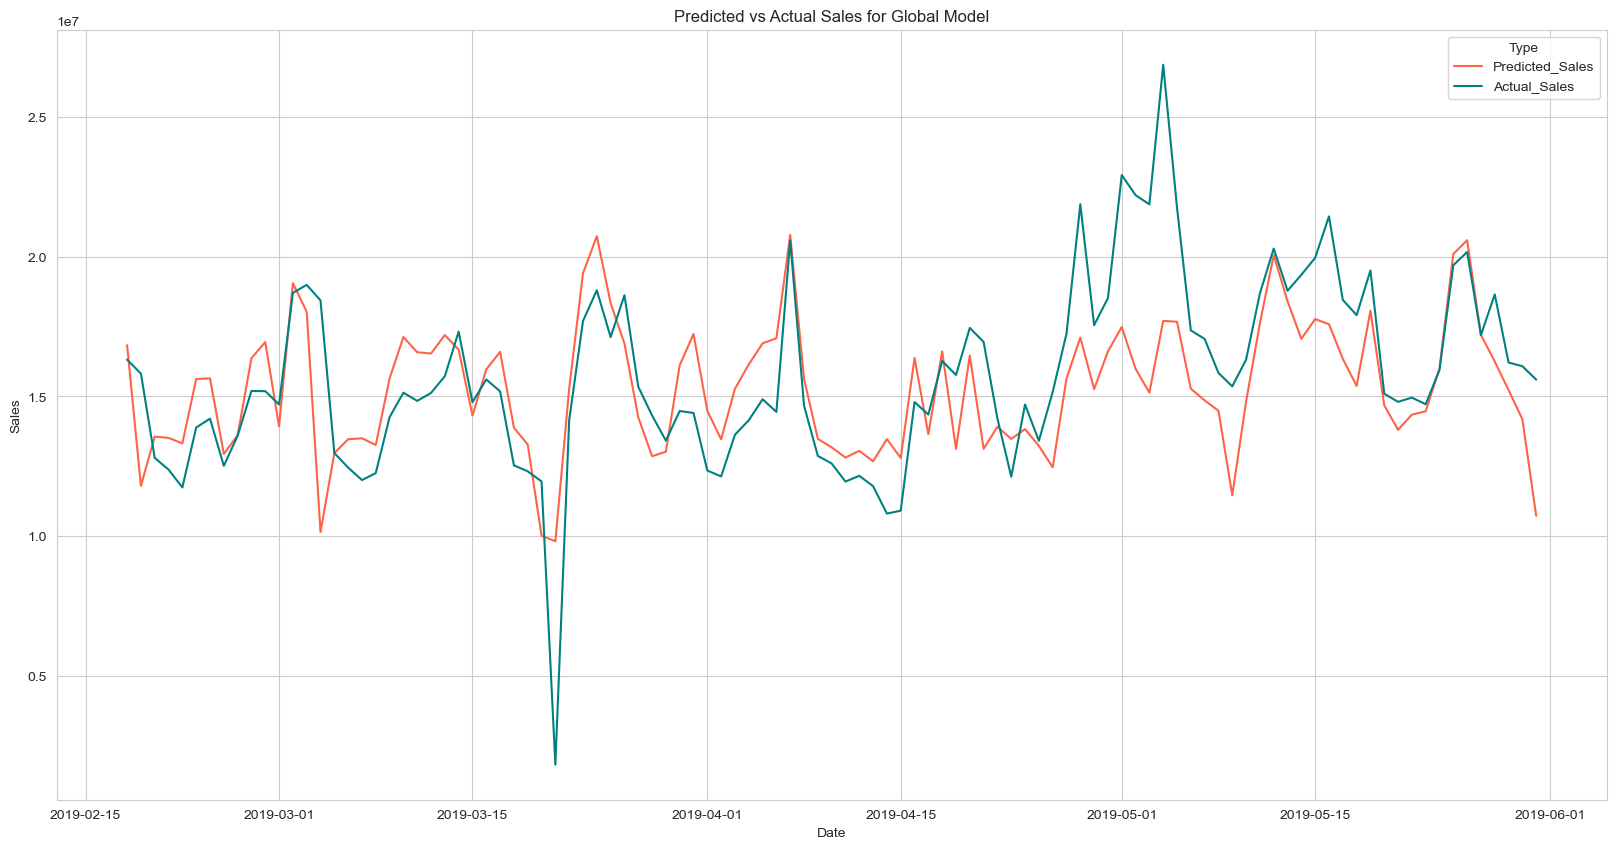

In [73]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=out, x="Date", y="Sales", hue="Type", palette={"Actual_Sales": "teal", "Predicted_Sales": "tomato"})
plt.title("Predicted vs Actual Sales for Global Model")
plt.show()

# Prepare for deployment

In [37]:
train_agg = pd.read_parquet("../../data/processed/train_agg.parquet")
df = train_agg[["Date", "Total_Sales", "Total_Discounts"  ]].rename(columns={"Date": "ds", "Total_Sales": "y"})
df

,ds,y,Total_Discounts
0,2018-01-01,15345484,365
1,2018-01-02,19592415,365
2,2018-01-03,18652527,365
3,2018-01-04,19956267,364
4,2018-01-05,22902651,364
...,...,...,...
511,2019-05-27,17197023,321
512,2019-05-28,18652065,319
513,2019-05-29,16213497,193
514,2019-05-30,16082139,76


In [39]:
test_data = pd.read_csv("../../data/raw/TEST_FINAL.csv", parse_dates=["Date"])
test_data

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,T1188341,171,S4,L2,R3,2019-06-01,0,No
1,T1188342,172,S1,L1,R1,2019-06-01,0,No
2,T1188343,173,S4,L2,R1,2019-06-01,0,No
3,T1188344,174,S1,L1,R4,2019-06-01,0,No
4,T1188345,170,S1,L1,R2,2019-06-01,0,No
...,...,...,...,...,...,...,...,...
22260,T1210601,186,S2,L5,R2,2019-07-31,0,No
22261,T1210602,11,S4,L2,R1,2019-07-31,0,No
22262,T1210603,185,S1,L1,R3,2019-07-31,0,Yes
22263,T1210604,69,S1,L1,R4,2019-07-31,0,No


In [41]:
_=test_data[test_data["Holiday"]==1][["Holiday", "Date"]].drop_duplicates().rename(columns={"Date": "ds", "Holiday": "holiday"})
_["holiday"] = "Holiday"
all_holidays = pd.concat([ holiday_df,_])
all_holidays["ds"] = pd.to_datetime(all_holidays["ds"])
all_holidays

,ds,holiday
2,2019-01-13,Holiday
10,2019-03-21,Holiday
14,2019-04-14,Holiday
15,2019-04-17,Holiday
16,2019-04-19,Holiday
...,...,...
506,2018-10-18,Holiday
508,2018-11-13,Holiday
515,2018-12-24,Holiday
1460,2019-06-05,Holiday


In [42]:
all_holidays.to_parquet("../../deploy/data/holidays.parquet")

In [46]:
test=db.sql("""
       SELECT Date ds , Region_Code
        , sum(case when Discount='Yes' then 1 else 0 end) as Total_Discounts
        FROM test_data
        GROUP BY Region_Code, Date
       order by Region_Code, Date
       """).to_df()
test

,ds,Region_Code,Total_Discounts
0,2019-06-01,R1,6.0
1,2019-06-02,R1,5.0
2,2019-06-03,R1,22.0
3,2019-06-04,R1,21.0
4,2019-06-05,R1,82.0
...,...,...,...
239,2019-07-27,R4,9.0
240,2019-07-28,R4,1.0
241,2019-07-29,R4,1.0
242,2019-07-30,R4,0.0


In [3]:
train = train_region_code_agg[["Date","Total_Sales","Region_Code"]]
train

,Date,Total_Sales,Region_Code
0,2018-01-01,2286812,R4
1,2018-01-01,4436859,R2
2,2018-01-01,3527439,R3
3,2018-01-01,5094374,R1
4,2018-01-02,2545119,R4
...,...,...,...
2059,2019-05-30,1966320,R4
2060,2019-05-31,4351299,R2
2061,2019-05-31,1909319,R4
2062,2019-05-31,5900798,R1


In [8]:
train[["Date", "Total_Sales"]].groupby(["Date"]).sum().reset_index()

,Date,Total_Sales
0,2018-01-01,15345484
1,2018-01-02,19592415
2,2018-01-03,18652527
3,2018-01-04,19956267
4,2018-01-05,22902651
...,...,...
511,2019-05-27,17197023
512,2019-05-28,18652065
513,2019-05-29,16213497
514,2019-05-30,16082139


In [9]:
test.to_parquet("../../deploy/data/test_prophet.parquet")
train.to_parquet("../../deploy/data/train_prophet.parquet")

In [50]:
import pickle

for region in [1,2,3,4]:
    study = optuna.load_study(study_name=f"prophet_region_{region}", storage='sqlite:///optuna.db')
    best_params = study.best_params
    data = train[train["Region_Code"]==f"R{region}"]
    m = Prophet(holidays=all_holidays, yearly_seasonality=True, weekly_seasonality=True, **best_params)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.add_regressor("Total_Discounts")
    m.fit(data)
    # save model
    with open(f"../../deploy/models/prophet_region_{region}.pkl", "wb") as f:
        pickle.dump(m, f)

23:38:02 - cmdstanpy - INFO - Chain [1] start processing
23:38:02 - cmdstanpy - INFO - Chain [1] done processing
23:38:02 - cmdstanpy - INFO - Chain [1] start processing
23:38:02 - cmdstanpy - INFO - Chain [1] done processing
23:38:02 - cmdstanpy - INFO - Chain [1] start processing
23:38:02 - cmdstanpy - INFO - Chain [1] done processing
23:38:02 - cmdstanpy - INFO - Chain [1] start processing
23:38:02 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
# global model
study = optuna.load_study(study_name="prophet_global", storage='sqlite:///optuna.db')
best_params = study.best_params
m = Prophet(holidays=all_holidays, yearly_seasonality=True, weekly_seasonality=True, **best_params)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_regressor("Total_Discounts")
m.fit(train)
# save model

with open(f"../../deploy/models/prophet_global.pkl", "wb") as f:
    pickle.dump(m, f)



01:56:49 - cmdstanpy - INFO - Chain [1] start processing
01:56:49 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
train = pd.read_parquet("../../deploy/data/train_prophet.parquet")
train

,Date,Total_Sales,Region_Code
0,2018-01-01,2286812,R4
1,2018-01-01,4436859,R2
2,2018-01-01,3527439,R3
3,2018-01-01,5094374,R1
4,2018-01-02,2545119,R4
...,...,...,...
2059,2019-05-30,1966320,R4
2060,2019-05-31,4351299,R2
2061,2019-05-31,1909319,R4
2062,2019-05-31,5900798,R1


In [18]:
test = pd.read_parquet("../../deploy/data/test_prophet.parquet")
test.groupby("ds").sum().reset_index().drop(columns=["Region_Code"], axis=1)

,ds,Total_Discounts
0,2019-06-01,10.0
1,2019-06-02,12.0
2,2019-06-03,43.0
3,2019-06-04,43.0
4,2019-06-05,251.0
...,...,...
56,2019-07-27,92.0
57,2019-07-28,42.0
58,2019-07-29,39.0
59,2019-07-30,12.0


In [16]:
train.groupby(["Date"]).sum().drop("Region_Code", axis=1).reset_index()

,Date,Total_Sales
0,2018-01-01,15345484
1,2018-01-02,19592415
2,2018-01-03,18652527
3,2018-01-04,19956267
4,2018-01-05,22902651
...,...,...
511,2019-05-27,17197023
512,2019-05-28,18652065
513,2019-05-29,16213497
514,2019-05-30,16082139
